In [23]:
import pandas as pd

In [24]:
import pickle

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [27]:
import mlflow
from mlflow import MlflowClient

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("nyc-taxi-experiment4")

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1750595103034, experiment_id='1', last_update_time=1750595103034, lifecycle_stage='active', name='nyc-taxi-experiment4', tags={}>

In [28]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [29]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train) # type: ignore

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799886681

/var/folders/pd/gkktfyxj0qs5r0_9lgrcdgbc0000gn/T/ipykernel_94747/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/pd/gkktfyxj0qs5r0_9lgrcdgbc0000gn/T/ipykernel_94747/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

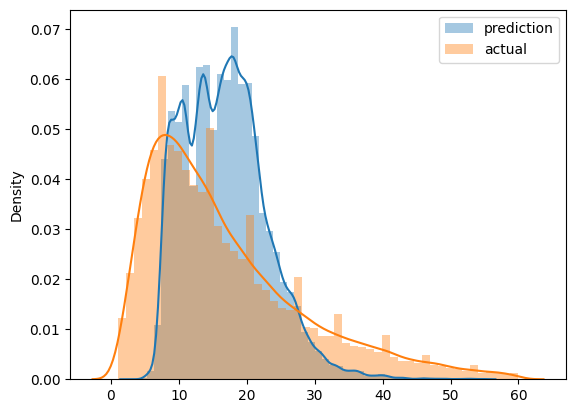

In [30]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [31]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    else:
        raise ValueError("Unsupported file format. Use .csv or .parquet")


    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [32]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [33]:
len(df_train), len(df_val)

(73908, 61921)

In [34]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [35]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [36]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [37]:


lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715203735939

In [38]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [39]:
import mlflow.sklearn
import mlflow.sklearn
import mlflow.sklearn
import mlflow.sklearn
import mlflow.sklearn


with mlflow.start_run():

    mlflow.set_tag("developer" , "cristian")

    mlflow.log_param("train-data-path" , './data/green_tripdata_2021-01.parquet')
    mlflow.log_param("val-data-path" , './data/green_tripdata_2021-02.parquet')
    

    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(0.01)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse" , rmse)
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")
    mlflow.sklearn.log_model(lr,"lasso")
  


2025/06/22 16:20:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run marvelous-goose-462 at: http://127.0.0.1:5000/#/experiments/1/runs/404a3bc8591a468c94ca4b5199f67362
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [40]:
import xgboost as xgb
from hyperopt import STATUS_OK, hp,tpe,Trials, fmin
from hyperopt.pyll import scope


In [41]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [42]:
def objective(params):

    with mlflow.start_run():
        mlflow.set_tag("model" , "xgboost")
        mlflow.log_params(params=params)
        booster = xgb.train(
            params=params,
            dtrain = train,
            num_boost_round = 10,
            evals = [(valid, "validation")],
            early_stopping_rounds = 10
        )
        y_pred = booster.predict(valid)
        rmse  = root_mean_squared_error(y_val, y_pred=y_pred)
        mlflow.log_metric("rmse", rmse)

    return {"loss" : rmse , "status" : STATUS_OK}


In [43]:
search_space = {
    "max_depth" : scope.int(hp.quniform("max_depth", 4,100,1)),
    "learning_rate" : hp.loguniform("learning_rate", -3,0),
    "reg_alpha" : hp.loguniform("reg_alpha", -5,-1),
    "reg_lambda" : hp.loguniform("reg_lambda", -6,-1),
    "min-child_weight" : hp.loguniform("min_child_weight", -1, 3),
    "objective" : "reg:linear",
    "seed" : 42,
}

best_results = fmin(fn=objective,
                    space=search_space,
                    algo=tpe.suggest,
                    max_evals=20,
                    trials=Trials())

[0]	validation-rmse:10.64825                          
  0%|          | 0/20 [00:01<?, ?trial/s, best loss=?]

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [16:20:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [16:20:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:9.49286                           
[2]	validation-rmse:8.65557                           
[3]	validation-rmse:8.05899                           
[4]	validation-rmse:7.63406                           
[5]	validation-rmse:7.34001                           
[6]	validation-rmse:7.13520                           
[7]	validation-rmse:6.98394                           
[8]	validation-rmse:6.87949                           
[9]	validation-rmse:6.80168                           
  0%|          | 0/20 [00:03<?, ?trial/s, best loss=?]

2025/06/22 16:20:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [16:20:24] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run nebulous-cub-440 at: http://127.0.0.1:5000/#/experiments/1/runs/2d308abe96ef4f8e883c7cb9912ab65b

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

  5%|▌         | 1/20 [00:09<02:54,  9.16s/trial, best loss: 6.801678267007991]

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [16:20:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [16:20:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.00135                                                    
[1]	validation-rmse:7.61052                                                    
[2]	validation-rmse:7.02941                                                    
[3]	validation-rmse:6.78150                                                    
[4]	validation-rmse:6.67505                                                    
[5]	validation-rmse:6.61626                                                    
[6]	validation-rmse:6.58130                                                    
[7]	validation-rmse:6.56285                                                    
[8]	validation-rmse:6.55390                                                    
[9]	validation-rmse:6.54100                                                    
  5%|▌         | 1/20 [00:12<02:54,  9.16s/trial, best loss: 6.801678267007991]

2025/06/22 16:20:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [16:20:42] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run peaceful-fox-993 at: http://127.0.0.1:5000/#/experiments/1/runs/34dac5054a0b4d1ab46b7739ec220734

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                   

 10%|█         | 2/20 [00:26<04:14, 14.14s/trial, best loss: 6.541003998447624]

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [16:20:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [16:20:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.52468                                                   
[1]	validation-rmse:10.91460                                                   
[2]	validation-rmse:10.37254                                                   
[3]	validation-rmse:9.89405                                                    
[4]	validation-rmse:9.47176                                                    
[5]	validation-rmse:9.09884                                                    
[6]	validation-rmse:8.77484                                                    
🏃 View run auspicious-shad-484 at: http://127.0.0.1:5000/#/experiments/1/runs/62f7f6c0e7ce401a8cfa00193da48324

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                   

 10%|█         | 2/20 [00:30<04:34, 15.23s/trial, best loss: 6.541003998447624]


KeyboardInterrupt: 

In [ ]:
import mlflow.runs
import mlflow.xgboost


params  = {
    "learning_rate" : 0.204,
    "max_depth" : 17, 
    "min_child_weight" : 1.2402,
    "objective" : "reg:linear",
    "reg_alpha" : 0.28567,
    "reg_lambda" : 0.0042,
    "seed" : 42
}

mlflow.xgboost.autolog()
booster = xgb.train(
    params  = params,
    dtrain = train,
    num_boost_round = 1000,
    evals = [(valid, "validation")],
    early_stopping_rounds = 50
)

2025/06/22 14:28:33 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the installed version is 3.0.2. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.
2025/06/22 14:28:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2747798ac0174da1804bd87268d18438', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:10.62644
[1]	validation-rmse:9.46235


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [14:28:34] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[2]	validation-rmse:8.62079
[3]	validation-rmse:8.02947
[4]	validation-rmse:7.61319
[5]	validation-rmse:7.31976
[6]	validation-rmse:7.11925
[7]	validation-rmse:6.97886
[8]	validation-rmse:6.87921
[9]	validation-rmse:6.80783
[10]	validation-rmse:6.75637
[11]	validation-rmse:6.71818
[12]	validation-rmse:6.68903
[13]	validation-rmse:6.66876
[14]	validation-rmse:6.65231
[15]	validation-rmse:6.63944
[16]	validation-rmse:6.62865
[17]	validation-rmse:6.61932
[18]	validation-rmse:6.61194
[19]	validation-rmse:6.60745
[20]	validation-rmse:6.60392
[21]	validation-rmse:6.60216
[22]	validation-rmse:6.60184
[23]	validation-rmse:6.60031
[24]	validation-rmse:6.59781
[25]	validation-rmse:6.59509
[26]	validation-rmse:6.59246
[27]	validation-rmse:6.59130
[28]	validation-rmse:6.58998
[29]	validation-rmse:6.58785
[30]	validation-rmse:6.58490
[31]	validation-rmse:6.58349
[32]	validation-rmse:6.58215
[33]	validation-rmse:6.58105
[34]	validation-rmse:6.57869
[35]	validation-rmse:6.57630
[36]	validation-rmse:6

2025/06/22 14:29:09 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/06/22 14:29:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [14:29:09] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/06/22 14:29:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run persistent-rook-434 at: http://127.0.0.1:5000/#/experiments/1/runs/2747798ac0174da1804bd87268d18438
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [45]:
import mlflow.xgboost


mlflow.xgboost.autolog(disable=True)

In [46]:
import mlflow.xgboost
import mlflow.xgboost


with mlflow.start_run():

    best_params  = {
    "learning_rate" : 0.204,
    "max_depth" : 17, 
    "min_child_weight" : 1.2402,
    "objective" : "reg:linear",
    "reg_alpha" : 0.28567,
    "reg_lambda" : 0.0042,
    "seed" : 42
    }
    
    mlflow.log_params(best_params)

    booster = xgb.train(
        params = best_params,
        dtrain = train, 
        num_boost_round = 1000,
        evals = [(valid, "validation")],
        early_stopping_rounds = 50
    )
    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val,y_pred) 
    mlflow.log_metric("rmse" , rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv,f_out)
    
    mlflow.log_artifact(local_path="models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflows")

[0]	validation-rmse:10.62644
[1]	validation-rmse:9.46235
[2]	validation-rmse:8.62079


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [16:22:06] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[3]	validation-rmse:8.02947
[4]	validation-rmse:7.61319
[5]	validation-rmse:7.31976
[6]	validation-rmse:7.11925
[7]	validation-rmse:6.97886
[8]	validation-rmse:6.87921
[9]	validation-rmse:6.80783
[10]	validation-rmse:6.75637
[11]	validation-rmse:6.71818
[12]	validation-rmse:6.68903
[13]	validation-rmse:6.66876
[14]	validation-rmse:6.65231
[15]	validation-rmse:6.63944
[16]	validation-rmse:6.62865
[17]	validation-rmse:6.61932
[18]	validation-rmse:6.61194
[19]	validation-rmse:6.60745
[20]	validation-rmse:6.60392
[21]	validation-rmse:6.60216
[22]	validation-rmse:6.60184
[23]	validation-rmse:6.60031
[24]	validation-rmse:6.59781
[25]	validation-rmse:6.59509
[26]	validation-rmse:6.59246
[27]	validation-rmse:6.59130
[28]	validation-rmse:6.58998
[29]	validation-rmse:6.58785
[30]	validation-rmse:6.58490
[31]	validation-rmse:6.58349
[32]	validation-rmse:6.58215
[33]	validation-rmse:6.58105
[34]	validation-rmse:6.57869
[35]	validation-rmse:6.57630
[36]	validation-rmse:6.57482
[37]	validation-rmse:

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [16:22:30] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/06/22 16:22:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run lyrical-sheep-495 at: http://127.0.0.1:5000/#/experiments/1/runs/b705016b54b145629a0c3238dbbfbddf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [55]:
import mlflow.xgboost


logged_model = "runs:/b705016b54b145629a0c3238dbbfbddf/models_mlflows"

loaded_model = mlflow.pyfunc.load_model(logged_model)

xgboost_model = mlflow.xgboost.load_model(logged_model)

xgboost_model.best_score



6.314769380665159

In [59]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "http://127.0.0.1:5000"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [ ]:
#client.create_experiment(name="New-experiment")
client.search_experiments()

[<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1750613271227, experiment_id='2', last_update_time=1750613271227, lifecycle_stage='active', name='New-experiment', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1750595103034, experiment_id='1', last_update_time=1750595103034, lifecycle_stage='active', name='nyc-taxi-experiment4', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1750595046334, experiment_id='0', last_update_time=1750595046334, lifecycle_stage='active', name='Default', tags={}>]

In [ ]:
from mlflow.entities import ViewType
runs = client.search_runs(experiment_ids=1,
                          filter_string="",
                          run_view_type=ViewType.ACTIVE_ONLY,
                          )


In [ ]:
for run in runs:

    print(f"run id : {run.info.run_id} , rmse: {run.data.metrics['rmse']:.4f}")

run id : b705016b54b145629a0c3238dbbfbddf , rmse: 6.3148
run id : e339cfae5d40478391e7ab461d5e891f , rmse: 6.3148


In [153]:
from pprint import pprint

client = MlflowClient()
for rm in client.search_registered_models():
    pprint(dict(rm), indent=4)

{   'aliases': {'adadada': '4', 'last': '4', 'scind': '2'},
    'creation_timestamp': 1750612521664,
    'description': 'nyc',
    'last_updated_timestamp': 1750621014807,
    'latest_versions': [   <ModelVersion: aliases=[], creation_timestamp=1750614579157, current_stage='None', description='edit', last_updated_timestamp=1750620872249, name='nyc-taxi', run_id='b705016b54b145629a0c3238dbbfbddf', run_link='', source='models:/nyc-taxi/3', status='READY', status_message=None, tags={'ff': 'tt'}, user_id='', version='4'>,
                           <ModelVersion: aliases=[], creation_timestamp=1750612701724, current_stage='Staging', description='', last_updated_timestamp=1750620899782, name='nyc-taxi', run_id='b705016b54b145629a0c3238dbbfbddf', run_link='', source='models:/nyc-taxi/1', status='READY', status_message=None, tags={}, user_id='', version='2'>],
    'name': 'nyc-taxi',
    'tags': {}}


In [169]:
for mv in client.search_model_versions("name='nyc-taxi'"):
    print(f"{mv}")

<ModelVersion: aliases=[], creation_timestamp=1750612701724, current_stage='None', description='', last_updated_timestamp=1750704995507, name='nyc-taxi', run_id='b705016b54b145629a0c3238dbbfbddf', run_link='', source='models:/nyc-taxi/1', status='READY', status_message=None, tags={}, user_id='', version='2'>
<ModelVersion: aliases=[], creation_timestamp=1750614579157, current_stage='None', description='edit', last_updated_timestamp=1750620872249, name='nyc-taxi', run_id='b705016b54b145629a0c3238dbbfbddf', run_link='', source='models:/nyc-taxi/3', status='READY', status_message=None, tags={'ff': 'tt'}, user_id='', version='4'>
<ModelVersion: aliases=[], creation_timestamp=1750612708874, current_stage='None', description='', last_updated_timestamp=1750620831067, name='nyc-taxi', run_id='b705016b54b145629a0c3238dbbfbddf', run_link='', source='models:/nyc-taxi/2', status='READY', status_message=None, tags={}, user_id='', version='3'>
<ModelVersion: aliases=[], creation_timestamp=1750612521

In [170]:
mv = client.search_model_versions("name='nyc-taxi'")[0]
mv.version

'2'

In [ ]:
client.set_registered_model_alias(name="nyc-taxi" , alias="deneme", version=mv.version)
client.set_

In [173]:
client.update_model_version("nyc-taxi" , mv.version, description="dededede")

<ModelVersion: aliases=['deneme', 'scind'], creation_timestamp=1750612701724, current_stage='None', description='dededede', last_updated_timestamp=1750705210131, name='nyc-taxi', run_id='b705016b54b145629a0c3238dbbfbddf', run_link='', source='models:/nyc-taxi/1', status='READY', status_message=None, tags={}, user_id='', version='2'>

In [184]:
import mlflow.cli


mlflow.pyfunc.load_model("models:/nyc-taxi/4")

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflows
  flavor: mlflow.xgboost
  run_id: b705016b54b145629a0c3238dbbfbddf

In [191]:
client.download_artifacts("e339cfae5d40478391e7ab461d5e891f",path="preprocessor", dst_path=".")

'/Users/denizcelebi/Desktop/Projects/MLOps/02-experiment-tracking/preprocessor'